dimer interaction is given by $a(x-x_{0})^2$
For all other particles of the system only Leonard Jones Energy will be considered for the PE Calculation. Hence if we have N particles in the system the potential energy of a configuration is:-

$$U=\sum_{i, j=1, i \ne j}^{N+2}U_{LJ} + a(x-x_{0})^2$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from mpl_toolkits import mplot3d
import math

In [9]:
epsilon =1
sigma = 1
kT=1
numParticles = 36
dimers=1
dim = 2 ## square box, periodic boundary conditions to be implemented
boxL = 6
a=2
x0=1
T=1

In [10]:
def initialize_positions(numParticles, dim, boxL, dimers):
    positions = np.random.random_sample( (numParticles+2*dimers, dim)) * boxL
    return positions

positions=initialize_positions(numParticles, dim, boxL, dimers)

#dimer positions will be initialized along with particle positions
#we will always assume that the last two indices of the positions
#array indicate the positions of the dimer.


# print(positions)
# print(positions[-1], positions[-2])
# print(np.shape(positions))


In [11]:
def pairwise_LJ_Energy(sigma, epsilon, particle,interaction, positions, boxL):
    dimensions=np.shape(positions)[1]
    r=0
    energy=0
    for dim in range(dimensions):

        ## Boundary Conditions Implemented
        positions[particle][dim]%= boxL
        positions[interaction][dim]%= boxL
        r+=(np.minimum(abs(positions[particle][dim]-positions[interaction][dim]), boxL-abs(positions[particle][dim]-positions[interaction][dim])))**2
        # print(math.sqrt(r))
        # print(r)
        
    energy+=4*epsilon*(((sigma**12)/(r**6)) - ((sigma**6)/(r**3)))
    # print(energy)
    return energy


pairwise_LJ_Energy(sigma, epsilon, 1, 2, positions, 6)

-0.0013591265710228351

In [12]:
def dimerEnergy(a, x0, positions, boxL):
    dimensions=np.shape(positions)[1]
    x=0.0
    for dim in range(dimensions):
        ## Boundary Conditions Implemented

        positions[-1][dim]%= boxL
        positions[-2][dim]%= boxL
        # print(min(abs(positions[-1][dim]-positions[-2][dim]),boxL-abs(positions[-1][dim]-positions[-2][dim])))
        x+=(np.minimum(abs(positions[-1][dim]-positions[-2][dim]), boxL-abs(positions[-1][dim]-positions[-2][dim])))**2
        
    return a*(x-x0**2)**2

dimerEnergy(a, x0, positions, boxL)

0.11501919251371985

In [13]:
def TotalPE(positions, a, x0, boxL, sigma, epsilon):
    totPE=0.0
    totPE+=dimerEnergy(a, x0, positions, boxL)
    numParticles=np.shape(positions)[0]

    ## we iterate through whole array because the dimer particles
    ## have leonard jones interactions as well

    for particle in range(numParticles):
        for interaction in range(particle+1, numParticles):
            totPE += 2*pairwise_LJ_Energy(sigma, epsilon, particle,interaction, positions, boxL)
    
    return totPE

TotalPE(positions, a, x0, boxL, sigma, epsilon)


680419076259340.6

In [14]:
def MCMC_Translate(positions, T):

    numParticles=np.shape(positions)[0]
    dimensions=np.shape(positions)[1]
    newPositions=np.matrix.copy(positions)

    # select a particle randomly

    choice=np.random.randint(0, numParticles-1)
    
    # print(choice)

    # perform random perturbation of the selected particle 
    # (we have used a gaussian distribution)
    
    for _ in range(dimensions):
        # print(positions[choices[_]][_])

        newPositions[choice][_]*=np.random.normal(loc=1, scale=0.05)
        # print(newPositions[choice]-positions[choice])
        # print(positions[choices[_]][_])
        # newPositions[-1][_]*=np.random.normal(loc=1, scale=0.05)
        # newPositions[-2][_]*=np.random.normal(loc=1, scale=0.05)
        
    # compute U_{after} - U_{before}, and acceptance probabilty
    U1=TotalPE(positions, a, x0, boxL, sigma, epsilon)
    U2=TotalPE(newPositions, a, x0, boxL, sigma, epsilon)
    
    # print(U2)
    delta=U2-U1
    # print(delta)

    # accept or reject?  i.e. set accept=1 or 0 accordingly
    if delta < 0:
        acceptProb=1
    else:
        x=np.random.rand()
        ##assuming k_B = 1
        if(x < math.exp((-1/T)*(delta))):
            acceptProb=1
        else:
            acceptProb=0
            
        
    # print(acceptProb)

    # if reject, undo the move, to get back to 'before' configuration
    if (acceptProb):
        # print("1")
        # print(newPositions[-1]-positions[-1])
        return newPositions
    else:
        # print("0")
        return positions
    # return accept

positions=MCMC_Translate(positions, T)


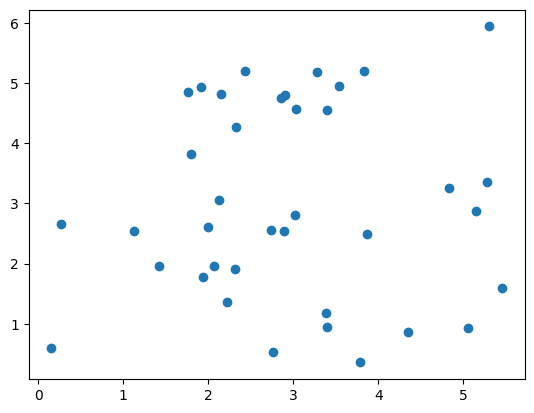

In [15]:
def Plot_XY(config):
    numParticles=np.shape(config)[0]
    X=[]
    Y=[]
    for _ in range(numParticles):
        X.append(config[_][0])
        Y.append(config[_][1])
    
    plt.scatter(X, Y)
    plt.show()


Plot_XY(positions)

In [16]:


# generate chain of configurations
def MonteCarloSimulation(initial_config, numSteps, boxL, T):
    x_dist=[]
    dimensions=np.shape(initial_config)[1]
    systemState=np.matrix.copy(initial_config)

    for stepNumber in range(numSteps):
        systemState=MCMC_Translate(systemState, T)
        if stepNumber % 38 == 0:
            x=0
            for dim in range(dimensions):
             ## Boundary Conditions Implemented
                systemState[-1][dim]%= boxL
                systemState[-2][dim]%= boxL
                x+=(np.minimum(abs(systemState[-1][dim]-systemState[-2][dim]), boxL-abs(systemState[-1][dim]-systemState[-2][dim])))**2
        
            x_dist.append(math.sqrt(x))
        
      
        
    return x_dist


# np.shape(MonteCarloSimulation(positions2D, 10))
x_Values=MonteCarloSimulation(positions, 2280, boxL, 1)


We consider the first 570 steps of this Monte Carlo Simulation to be equillibration steps. We will start recording the system's probability distribution x_values after that. We have recorded the x values every 38 steps because each step in the markov chain is highly correlated. By giving #numParticles time steps between each observation we will assume that the system has gotten enough time for the previous state to be $\bold{decorrelated}$ with the next state.

(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
         0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([1.49278503, 1.5029842 , 1.51318337, 1.52338254, 1.53358171,
        1.54378088, 1.55398006, 1.56417923, 1.5743784 , 1.58457757,
        1.59477674, 1.60497591, 1.61517509, 1.62537426, 1.63557343,
        1.6457726 , 1.65597177, 1.66617094, 1.67637012, 1.68656929,
        1.69676846, 1.70696763, 1.7171668 , 1.72736597, 1.73756514,
        1.74776432, 1.75796349, 1.76816266, 1.77836183, 1.788561  ,
        1.79876017, 1.80895935, 1.81915852, 1.82935769, 1.83955686,
        1.84975603, 1.8599552 , 1.87015438, 1.88035355, 1.89055272,
        1.90075189, 1.91095106, 1.92115023, 1.9313494 , 1.94154858,
        1.95174775, 1.96194692, 1.97214609, 1.98234526, 1.99254443,
        2.00274361]),
 <BarContainer

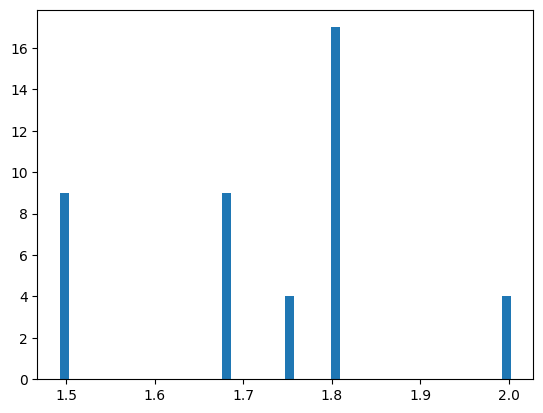

In [17]:
plt.hist(x_Values[15:], 50)


# maxima=np.amax(x_Values)
# minima=np.amin(x_Values)
# dx=np.linspace(minima, maxima, 100)
# print(dx)
# for x in x_Values:
#     for i in dx:
#         if((i != dx[99] and i != dx[0]) and (x <= i) and (x > i-1)):
# print(maxima, minima)
# t=np.linspace(15, 45, 1)
# plt.plot(x_Values[15:], )


This plots the probability distribution for a given kT. We see that the maximum probability of the x value peaks around 1.95 and 1.85. We know that $\beta = \frac{1}{k_{B}T}$ so by plotting values for different T, we will be able to see the probability distribution of x vs T.



In [18]:
T_vals=np.linspace(1, 301, 12)

ans=[]
for t in T_vals:
    x_vals=0
    x_vals=MonteCarloSimulation(positions, 1140, boxL, t)
    ans.append(np.mean(x_vals[15:]))

plt.plot(x_vals, t)


/tmp/ipykernel_141073/680736544.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  if(x < math.exp((-1/T)*(delta))):
